<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/BulkAnalyze_general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import scipy

def max_circautocorr(signal):
  signal = signal - np.mean(signal)
  ps = np.square(np.abs(scipy.fft.fft(signal)))
  autocorr = np.real(scipy.fft.ifft(ps))
  #divide by variance to normalize
  variance = autocorr[0]/len(signal)
  autocorrz = autocorr[1:]/(variance*np.sqrt(len(signal)))
  argmax_autocorrz = np.argmax(autocorrz)
  return ((autocorrz[argmax_autocorrz], argmax_autocorrz+1)) #index '0' = shift of 1



In [16]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs


def perform_imabalance_test(orig_egg_values):
  orig_egg_values = np.where((orig_egg_values < 55), np.nan, orig_egg_values)
  orig_egg_values = np.where((orig_egg_values > 145), np.nan, orig_egg_values)

  proportion_nonnan_for_each_egg = np.mean(np.isnan(orig_egg_values), axis=0)
  print("Columns with over 5% nans:", np.sum(proportion_nonnan_for_each_egg > 0.05) )
  egg_values_dropeggswithtoomanynans = orig_egg_values[:, proportion_nonnan_for_each_egg <= 0.05 ]
  #Replace remaining nans with 100, exactly the expected value

  egg_values_to_use = np.where(np.isnan(egg_values_dropeggswithtoomanynans), 100, egg_values_dropeggswithtoomanynans)
  sum_eggs = np.nansum(egg_values_to_use, axis=1)
  num_nonnan_eggs = np.sum(np.isnan(egg_values_to_use)==False, axis=1)

  #For a given row, we deem 1s to be 'dominant'
  # if z_sum_eggs is positive, and 0s to be 'dominant' if z_sum_eggs is negative
  #First we exclude rows where exactly the expected number of bits were generated
  matchexpected = ((sum_eggs - num_nonnan_eggs*100)==0)
  onesdominate_excludematchexpected = ((sum_eggs - num_nonnan_eggs*100)[matchexpected==False]) > 0
  egg_values_to_use_excludematchexpected = egg_values_to_use[matchexpected==False]
  #now transform based on whether 1s or 0s are dominant
  egg_values_to_use_excludematchexpected_dominanttransformed = (
      egg_values_to_use_excludematchexpected*onesdominate_excludematchexpected[:,None]
     + (200 - egg_values_to_use_excludematchexpected)*(onesdominate_excludematchexpected[:,None]==False))
  sum_eggs_dominant_excludematchexpected = (
          (sum_eggs[matchexpected==False])*onesdominate_excludematchexpected
         +((200*num_nonnan_eggs - sum_eggs)[matchexpected==False])*(onesdominate_excludematchexpected==False)
  )
  assert np.max(np.abs(np.nansum(egg_values_to_use_excludematchexpected_dominanttransformed, axis=1)
                       - sum_eggs_dominant_excludematchexpected))==0
  assert all((sum_eggs_dominant_excludematchexpected > 100*(num_nonnan_eggs[matchexpected==False])))

  peregg_sumdominant = np.sum(egg_values_to_use_excludematchexpected_dominanttransformed, axis=0)
  assert np.sum(peregg_sumdominant)==np.sum(sum_eggs_dominant_excludematchexpected)

  f_exp = np.sum(peregg_sumdominant)/len(peregg_sumdominant)
  #print((peregg_sumdominant-f_exp)/f_exp)

  return scipy.stats.chisquare(peregg_sumdominant, f_exp=f_exp).pvalue

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

Make a q-q plot for the events, to understand if there is enrichment of both negative and positive events

In [5]:
import scipy
import numpy as np
event_zscores = scipy.stats.norm.ppf([(1-x[2]) for x in event_metadata_list])
event_cdftoz = scipy.stats.norm.ppf(1 - ((np.arange(len(event_zscores))+1)/len(event_zscores)))

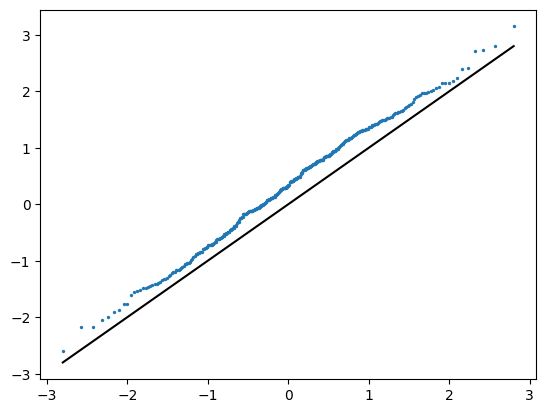

In [6]:
plt.scatter(event_cdftoz, event_zscores, s=2)
plt.plot(event_cdftoz, event_cdftoz, color="black")
plt.show() #looks like there's just a consistent bias in the positive direction

/content/drive/MyDrive/GCP_data

--------------------------------
Event Count: 1 Event391 Internat Day Peace 0.0008192443394802185
Columns with over 5% nans: 3
[ 3.23894555e-04 -1.30103025e-04  9.34818140e-05 -3.72204207e-04
 -2.92005298e-04  7.67708146e-04 -1.33922021e-04  1.63843917e-04
  3.02947942e-05 -2.91426662e-04 -4.77052999e-06  3.43452442e-05
 -1.29755844e-04 -3.16307998e-04  8.34135526e-05 -3.31583980e-04
 -1.86462144e-04  2.25179302e-04  1.88840979e-04 -2.82515672e-04
  5.09405164e-04 -6.48329169e-05  2.24832121e-04 -1.95951769e-04
  8.61910040e-05 -3.11563185e-05  2.67188255e-04  6.92948412e-05
 -2.51385071e-04  3.18802560e-04 -3.17002360e-04  1.26001141e-04
  2.68808435e-04 -6.63373698e-05 -2.81705582e-04 -2.59948879e-04
 -1.28714300e-05  2.11523499e-04  3.82799670e-05  2.19161491e-04
 -5.73106527e-05 -1.12743954e-04  7.14010752e-04  5.89256892e-04
 -6.29812827e-05  7.80901040e-05 -8.93670712e-05 -3.26144805e-04
 -1.03948691e-04 -4.65943193e-04  8.34135526e-05 -1.81948785

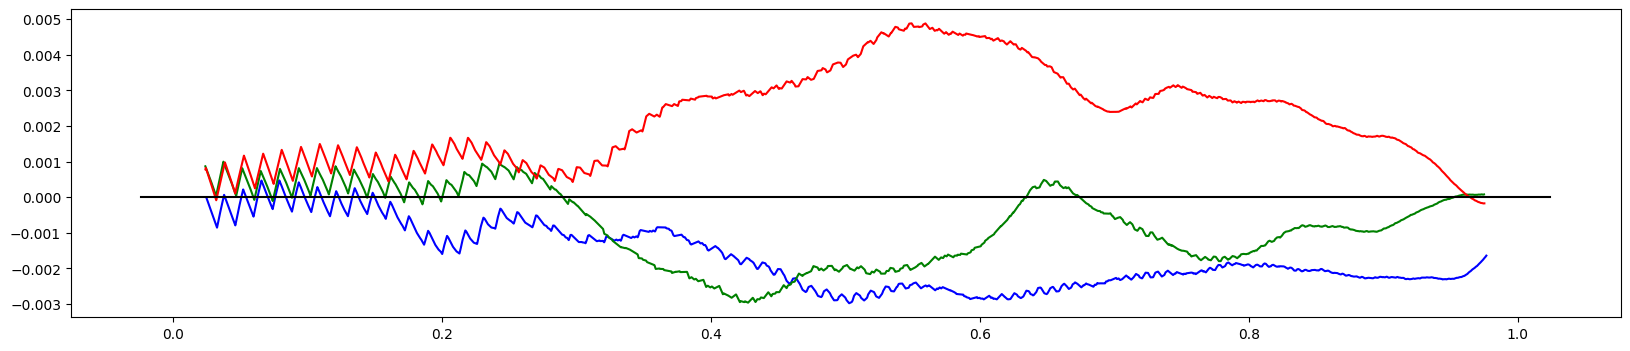


--------------------------------
Event Count: 2 Event289 Meditations Valentines Day 0.002569859448349643
Columns with over 5% nans: 5
[-6.44234756e-05  3.01742658e-04 -2.42239214e-04  1.98016810e-04
 -2.88834810e-05  2.02010719e-05  1.53447110e-04  2.73148591e-04
 -7.83153302e-05  1.36892650e-04  2.46001591e-05 -2.26321464e-05
  2.40850029e-04  1.12003078e-04 -5.28469301e-05 -1.18022881e-04
 -1.06909397e-04 -2.51963512e-04  4.52064101e-05  2.60472273e-06
 -1.79262807e-04 -2.93176014e-04  2.97806632e-04  1.36082292e-04
 -1.35850761e-04 -2.31473027e-04  2.00332120e-04  4.94839436e-04
 -1.36313823e-04 -1.37818774e-04 -1.57730432e-04 -1.70464632e-04
  1.21843141e-04  1.77757856e-04  2.74942955e-05  3.21885847e-04
 -8.97182275e-06  5.04158556e-05  1.11424250e-04  7.50738974e-05
 -1.17328288e-04 -3.44807407e-04 -1.61319161e-04  1.18254412e-04
 -3.60609392e-05  3.59451737e-05  9.20335366e-06 -1.61203396e-04
  4.32673387e-04  2.57578137e-05 -2.05773096e-04 -6.60441920e-05
 -2.80731228e-05  1.

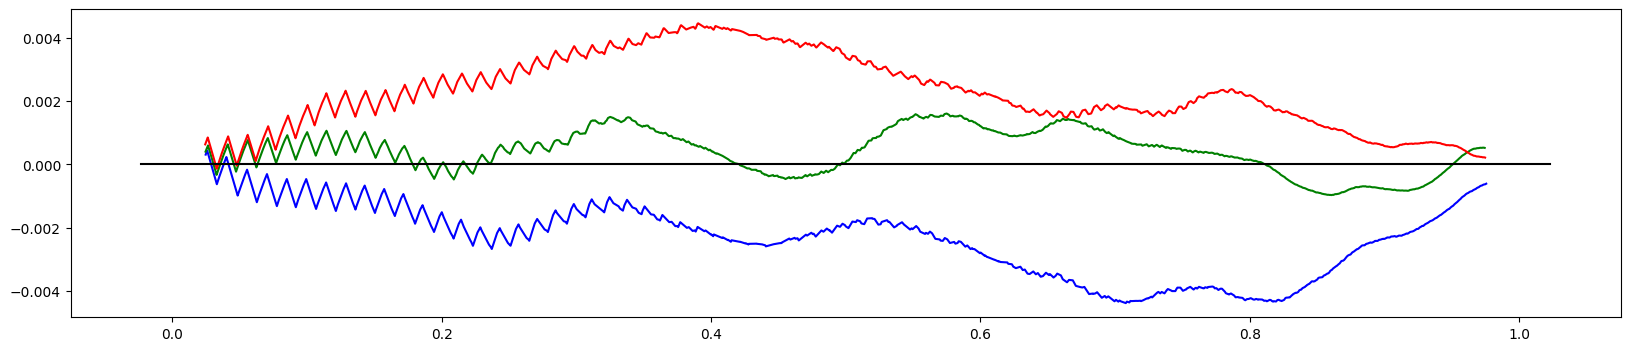


--------------------------------
Event Count: 3 Event487 September 21 0.003153268038066148
Columns with over 5% nans: 2
[-1.86704022e-05  1.18226124e-04  2.71670581e-04 -1.08121809e-04
 -2.00675072e-06 -2.07533587e-05 -1.92365825e-04 -1.51053856e-04
 -4.82946716e-05  1.64282605e-04 -1.58807083e-04  4.33446865e-04
 -9.68969885e-05 -2.51151485e-04 -1.33233006e-04  2.35103124e-04
 -2.27891804e-04 -3.94296880e-04  4.01161040e-04  7.37327065e-04
 -1.26289818e-04 -1.32885847e-04  7.82943247e-06  5.49273919e-05
 -8.03490568e-05 -4.40353361e-04  8.61717385e-05  1.47734673e-04
 -6.93556756e-05  2.50030978e-04 -8.67136459e-05 -1.20388108e-04
 -9.28467954e-05 -1.93754463e-04  3.73272568e-04 -1.13560640e-04
 -1.45044893e-05 -6.05609706e-05  3.66351959e-06  2.52461094e-04
 -2.02202008e-04]
0.9986863709264978


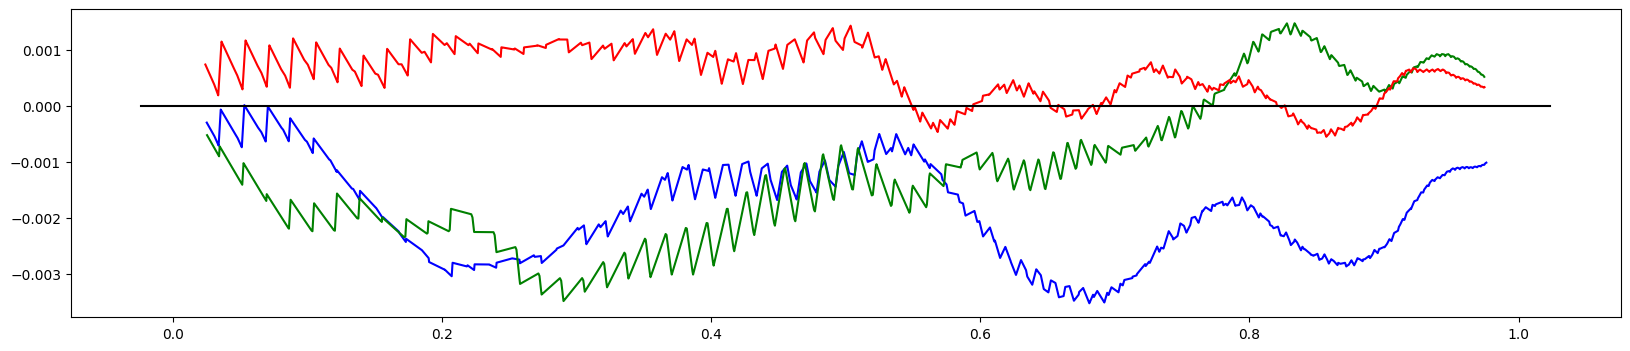


--------------------------------
Event Count: 4 Event217 Indonesian Earthquake 0.0032705236405630167
Columns with over 5% nans: 7
[ 6.82564105e-04  4.05582763e-04  4.32309033e-04  2.00449965e-04
 -1.19718158e-05 -2.69515870e-04 -3.46917924e-04 -8.00023207e-05
  3.41717391e-04 -3.68437778e-04 -4.47228210e-04 -4.90267917e-04
  6.23210960e-04  3.09784705e-04  2.59456015e-04  1.71294034e-04
 -6.36888833e-05  7.96611093e-05  1.33807838e-04 -7.87380734e-04
  1.09858323e-04  1.71841149e-05  2.79240397e-04 -1.51503770e-04
 -3.20538749e-04 -1.59486941e-04 -1.22263713e-03  4.51052131e-04
 -1.73370718e-04 -3.97246614e-04 -2.08427254e-04  1.91772605e-04
  3.13949838e-04  2.77157830e-04 -1.57751469e-04 -3.24356787e-04
  9.56274522e-05 -1.82395173e-04  1.88995849e-04  5.04504671e-04
  7.06366545e-05 -6.34312098e-04  1.91196075e-06 -2.57020471e-04
  9.49332634e-05 -3.27133543e-04  4.04194385e-04  3.99452723e-06
 -1.72676529e-04  8.59088087e-05  6.30847037e-04 -6.38130137e-04
  1.96137758e-05  5.1838

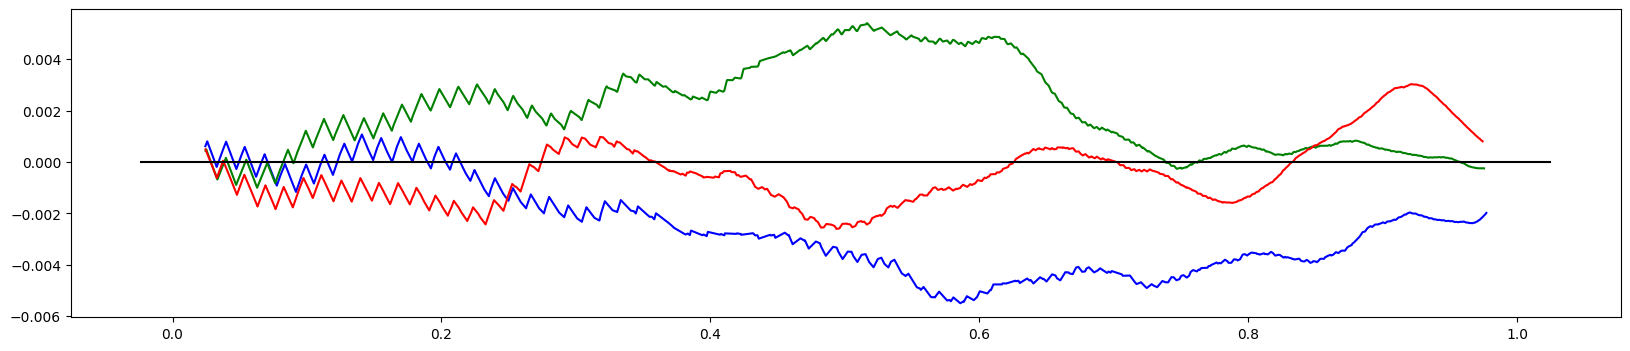


--------------------------------
Event Count: 5 Event203 Baghdad Bridge Stampede 0.007938503795130725
Columns with over 5% nans: 5
[ 8.91763392e-05 -3.22580796e-04 -4.04265409e-04  8.19336764e-04
 -8.03053425e-05 -1.82550029e-04 -9.48829501e-04 -7.33226575e-04
 -1.93107904e-04  4.85930178e-04  1.44744104e-04  2.79218094e-04
 -3.07577499e-04 -1.21055367e-03 -4.67612661e-04 -2.14779333e-04
  1.13626156e-04 -2.52009735e-04 -1.03088126e-04  7.73215520e-04
 -4.61500207e-04  1.33074873e-04 -1.59767246e-04 -8.16578222e-04
  5.55389883e-04 -6.97474672e-05  3.63125418e-04  6.34851786e-04
 -4.56499108e-04 -1.83105707e-04  1.58268901e-05  8.53233101e-04
 -3.84261014e-04 -1.89773839e-04 -1.50876403e-04  8.86206615e-05
 -2.51454057e-04 -5.32626945e-04  5.90953252e-04  4.52033841e-04
 -2.19591898e-05  1.75862052e-04 -1.56433180e-04  7.94331270e-04
 -6.07643427e-04 -4.43162845e-04  4.70926881e-04  5.77616989e-04
 -2.63123288e-04  8.34895738e-04 -7.66567234e-04  5.40386587e-04
 -2.36262227e-05  2.527

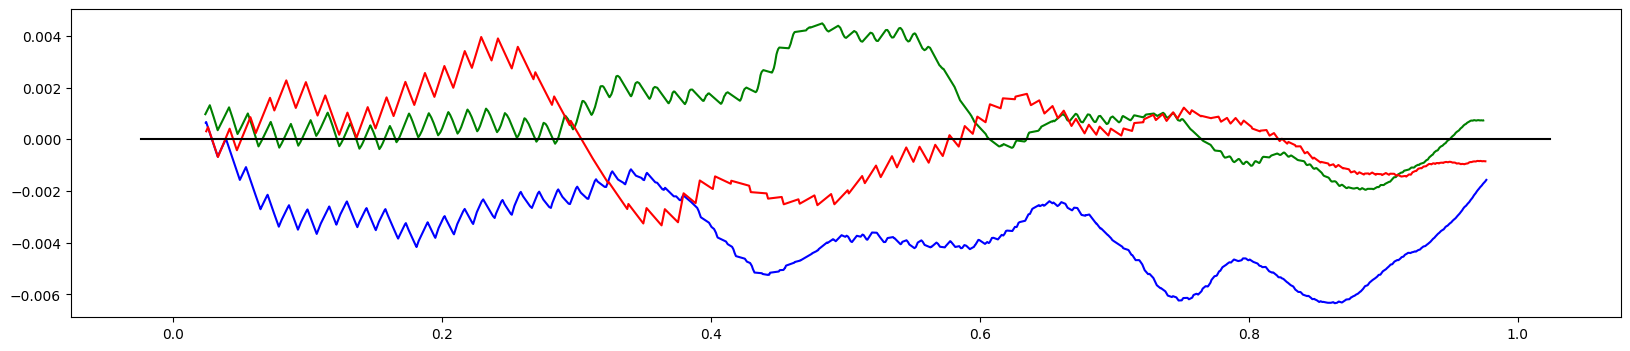


--------------------------------
Event Count: 6 Event472 Mandela Dies 0.008229306940944703
Columns with over 5% nans: 3
[ 2.19815249e-05  1.03449277e-04  2.26345233e-04 -2.80513794e-04
  2.24840857e-04 -1.44888502e-04  1.08656733e-04  9.76632151e-05
 -1.73636964e-05  3.42479762e-05  3.77196134e-05 -1.46971484e-04
  4.77873611e-05  3.57457397e-04  5.84965352e-04 -2.51930648e-04
 -4.02765017e-05  1.97646366e-04  2.76518656e-05  5.47306355e-05
  1.29486556e-04 -1.18851223e-04  4.35056753e-05 -1.30076183e-04
  7.78748833e-05 -2.09113789e-04 -1.34357869e-04 -1.17115404e-04
 -1.93375701e-04 -8.15889840e-05  3.07763390e-05 -4.39746218e-04
 -6.52722893e-05  1.49043445e-04 -1.64792555e-04 -1.10982179e-04
  5.79295012e-04 -2.60031134e-04 -2.18950095e-04 -1.46045714e-04
  9.70846089e-05  4.00340381e-05]
0.9999220915960872


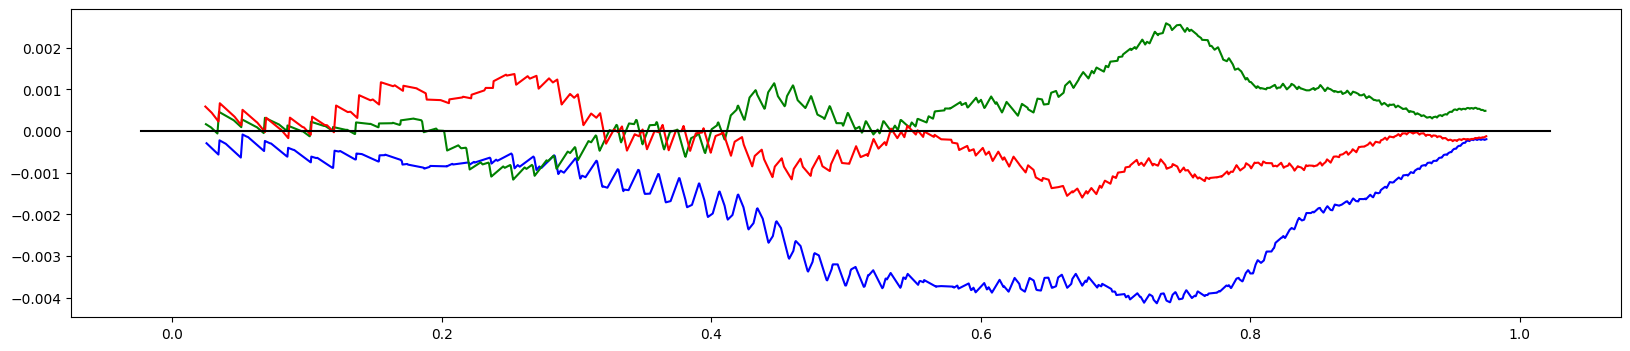


--------------------------------
Event Count: 7 Event360 Brazilian Mudslides 0.012434298335079697
Columns with over 5% nans: 2
[ 2.78520127e-04  2.42296208e-04  1.51099886e-04 -1.56051176e-04
 -3.74204814e-04  4.07676339e-04  1.54340365e-04 -5.21244038e-05
 -2.97822108e-04 -9.17045332e-05  3.35344231e-04 -1.59754580e-04
 -7.10489991e-06  2.74353798e-04 -1.95399843e-04  5.43484589e-05
  4.03449628e-05 -1.61017562e-07 -2.14611251e-04  2.38824267e-04
 -1.70633329e-04 -1.23530661e-04  1.27606418e-04 -2.84397268e-04
 -2.00607755e-04 -1.77521862e-05  2.16025186e-04  2.05548981e-05
 -3.58696810e-04 -2.74736215e-05 -1.71906374e-04  4.83304275e-05
  4.98872661e-04 -3.41452835e-04  2.24705039e-04  2.12553245e-04
 -1.48181443e-04 -2.34054121e-04 -1.62476783e-05 -5.91316868e-04
  1.15686086e-04  7.54115687e-05 -5.84372986e-04 -2.55232963e-04
  1.35013226e-04 -4.22117602e-04  1.04460143e-04  1.76097863e-04
  6.54586707e-05  1.16959131e-04  1.29110926e-04 -5.06198960e-05
 -1.34409410e-04  1.5480329

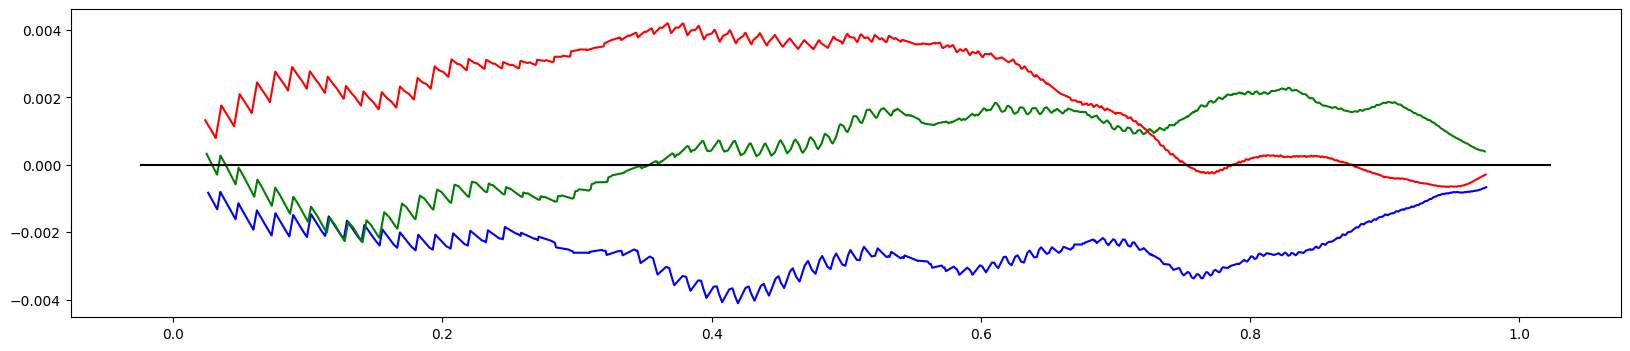


--------------------------------
Event Count: 8 Event266 Obama Wins Nomination 0.014699315651582556
Columns with over 5% nans: 2
[-4.68937667e-05  3.07788145e-05 -2.26316272e-04 -4.32825787e-04
 -1.10328304e-04 -5.36076411e-05  1.56143055e-04 -7.08553528e-05
 -2.49814832e-04 -2.21177512e-06 -3.37789738e-04 -9.17961089e-04
  3.41006114e-04 -9.38867532e-06  6.63160462e-05  1.63435712e-04
  3.62193679e-05  6.93298481e-06 -2.61274721e-04 -2.73892175e-04
  1.87281541e-04  8.09054936e-06  3.36260099e-04  1.54985491e-04
  2.78266115e-04 -2.90672726e-05 -4.74382354e-04  7.03323817e-04
  2.51294861e-04 -1.39031771e-05 -2.51315532e-05  1.93763903e-04
  3.61036114e-05  1.31834200e-04 -1.65655755e-05  2.04529253e-04
 -6.85402237e-05  2.98407738e-04  2.77918846e-04  8.99303629e-05
  6.02967105e-05 -2.17055755e-04 -8.31255371e-05 -1.02572621e-04
  1.49201802e-05 -3.45198151e-04 -7.28232126e-05 -1.90779040e-04
  8.56473741e-05  4.40903934e-04  6.85154188e-05  2.70741945e-04
 -2.18676346e-04  6.55057

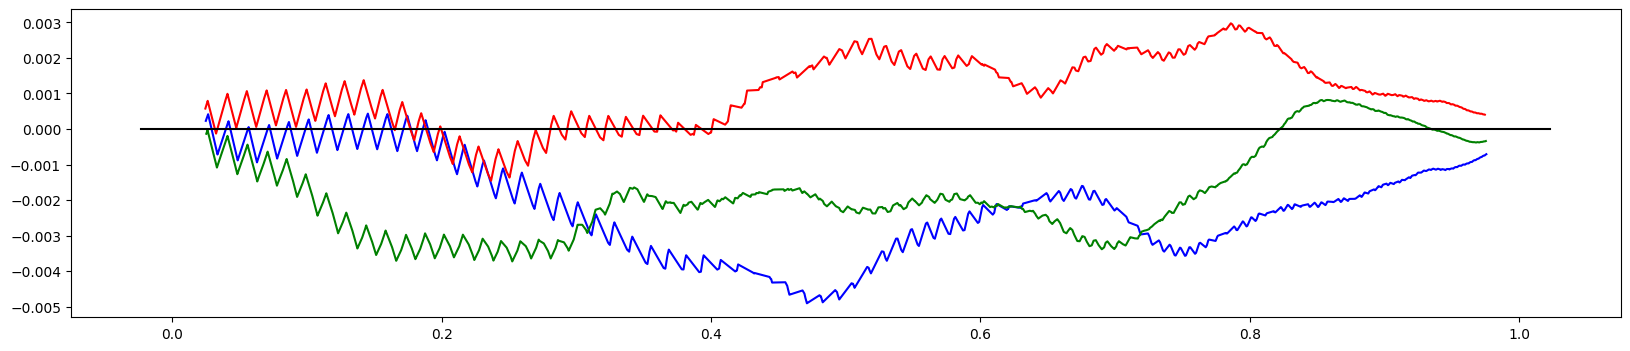


--------------------------------
Event Count: 9 Event395 Steve Jobs Dies 0.015513261511045151
Columns with over 5% nans: 4
[ 3.82175811e-04 -1.87586705e-04  4.05318074e-04  3.53016560e-04
 -5.93785678e-05 -2.73213078e-04 -1.01654257e-03 -9.13148908e-05
  1.16039786e-04  1.08153500e-03  3.02566426e-04 -3.57734595e-05
  7.70040140e-04  1.58621550e-04 -4.99081566e-04  1.33165061e-04
  4.10588538e-05  3.11360486e-04 -3.33382962e-04 -7.94376842e-04
 -2.05637670e-04 -6.03042583e-05 -5.32869270e-04 -1.01960332e-04
 -3.59302297e-04 -4.30580467e-04 -5.15281150e-04 -5.24358889e-05
 -3.59765142e-04  5.29360604e-04 -1.16048744e-03  5.95726642e-05
 -4.93990268e-04 -4.51408504e-04 -7.23382351e-05 -3.77353262e-04
  5.26120687e-04  2.95160902e-04  1.85929420e-04  1.95186326e-04
 -1.03169702e-05  5.33989057e-04  6.33500788e-04 -2.05637670e-04
 -8.62235930e-05  2.15088672e-04  1.71118372e-04  8.00125082e-04
  1.28999453e-04 -1.95455075e-04  5.36303283e-04 -3.42177022e-04
  2.61373198e-04  1.64175693e-0

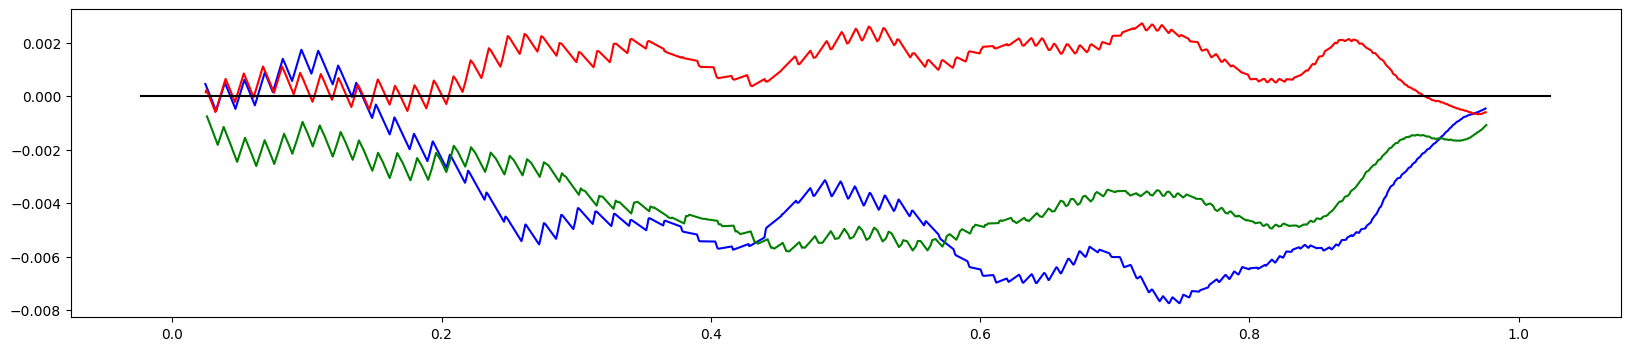


--------------------------------
Event Count: 10 Event341 Chilean Miners Alive 0.0159787032720784
Columns with over 5% nans: 1
[-2.83549875e-04  1.68210560e-04 -1.92133188e-04  4.98004935e-04
 -4.79494020e-05 -3.80058123e-04 -8.42846419e-05 -5.86960700e-04
 -1.60426641e-04  5.29561049e-05  1.66359083e-04 -6.25378851e-04
 -1.35200265e-04  5.51234904e-04  2.00148542e-04  5.93124576e-04
  3.74418832e-04 -2.31858946e-05  5.61961900e-05  7.11850551e-04
  2.54072815e-04  5.96677098e-05  4.78645427e-05  6.00067615e-04
  1.29329539e-04 -5.62810494e-05 -1.32885918e-04  2.48518383e-04
  2.49525124e-05 -5.39285162e-04  7.92389808e-04  4.67224127e-04
  4.59586783e-04 -2.18053869e-04 -4.69854767e-04 -5.58031368e-04
 -1.68526854e-04  3.12394346e-04 -7.98029099e-04 -2.12268003e-04
  3.12012479e-05  1.12434810e-04 -4.85823758e-04  3.43869459e-04
  1.56951264e-05  1.63813302e-04 -1.66675377e-04  1.70837343e-05
  5.65352418e-04 -2.60869279e-04 -1.77321371e-04 -2.41116332e-05
 -5.33730730e-04  9.8780165

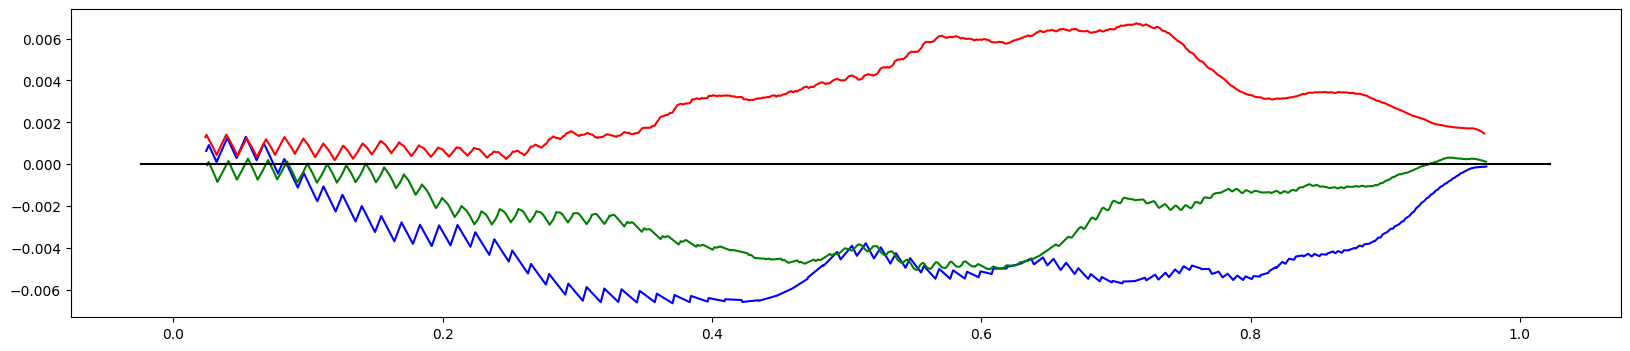


--------------------------------
Event Count: 11 Event199 Oraworld Resonance 0.016077254762331683
Columns with over 5% nans: 5
[-5.99345719e-04 -1.78262626e-05 -1.31575779e-04 -6.47229930e-05
  1.51001967e-04  9.71309389e-06  2.78122040e-04  1.18673157e-04
 -4.46881455e-04 -2.23972316e-04  2.97678974e-04  3.64542082e-05
  1.96911216e-05 -2.21777149e-04 -3.65261188e-04  1.90714517e-04
  7.97588485e-05 -2.43130129e-04 -1.77474706e-04  9.11441223e-06
 -1.19602145e-04 -3.75827575e-05 -1.62906786e-04  9.61228140e-05
 -2.38540236e-04  3.59742307e-04  1.96900894e-04  3.98656615e-04
 -1.40346121e-05  2.60959832e-04 -8.88698201e-05  1.22065686e-04
 -5.47449652e-05 -5.11528753e-05 -2.58086848e-05  1.69960219e-04
 -2.03218018e-04  3.42590421e-05  5.19989432e-04 -6.69181591e-05
  5.54124609e-05  7.73641219e-05  5.22783280e-04  2.34418278e-04
 -1.93838672e-04 -2.62078059e-05 -1.21996872e-04 -6.00942203e-04
 -3.37123150e-04  1.92710122e-04  3.84498137e-05  2.72744227e-05
  1.23063489e-04  4.1721574

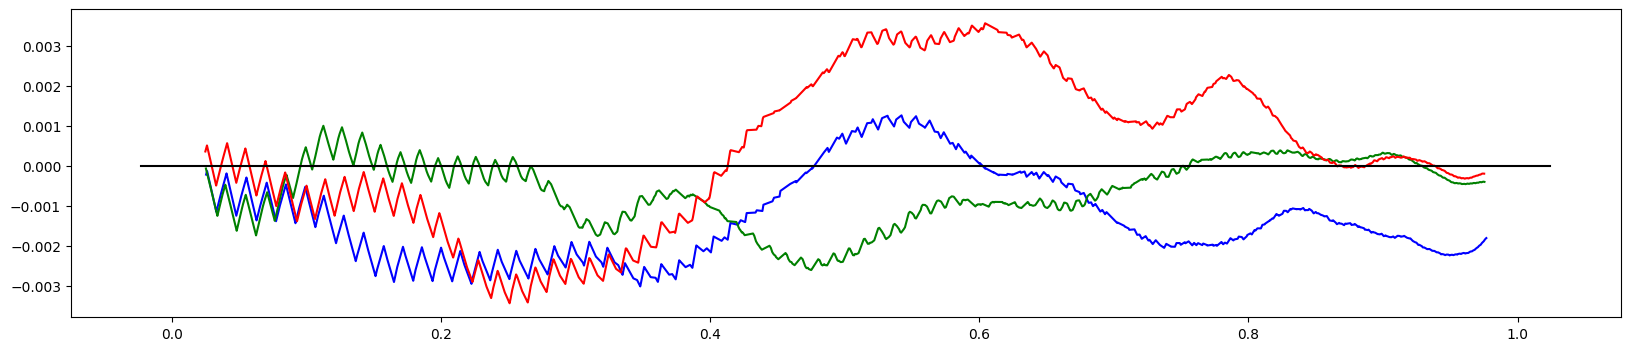


--------------------------------
Event Count: 12 Event437 Dr. Tomorrow Passes 0.01899878662499621
Columns with over 5% nans: 1
[-1.15346379e-06 -9.84712883e-04  1.79906674e-04  5.30256568e-05
  2.77151250e-04  3.52168493e-04 -3.39657200e-04  2.60017682e-04
 -1.91938059e-04 -2.81310455e-04  6.43439150e-04 -2.12776183e-04
  1.87315785e-04  2.28065892e-04  3.79489588e-04  1.09520124e-04
  3.20216704e-04  4.60526735e-04 -3.04926994e-04  1.14613888e-04
 -6.07311317e-04  3.93844740e-04  7.47899189e-05 -1.20625371e-04
  1.05352500e-04  3.40591758e-04  2.83634221e-04  4.74418817e-04
  1.17855374e-04  9.05342787e-05  1.27116762e-04  2.39642628e-04
 -2.03051725e-04  3.38739481e-04  7.52529883e-05  2.19267574e-04
 -1.17225599e-03 -3.72072058e-04 -6.51302911e-04  6.71686384e-04
  2.38716489e-04 -6.00828345e-04 -1.60912409e-04 -3.72535128e-04
 -1.22477648e-04  5.97132209e-04 -1.19236162e-04  7.36516101e-04
  4.21165835e-04  4.73029609e-04 -1.22087828e-03  1.72034494e-04
 -2.46117180e-04 -1.3266517

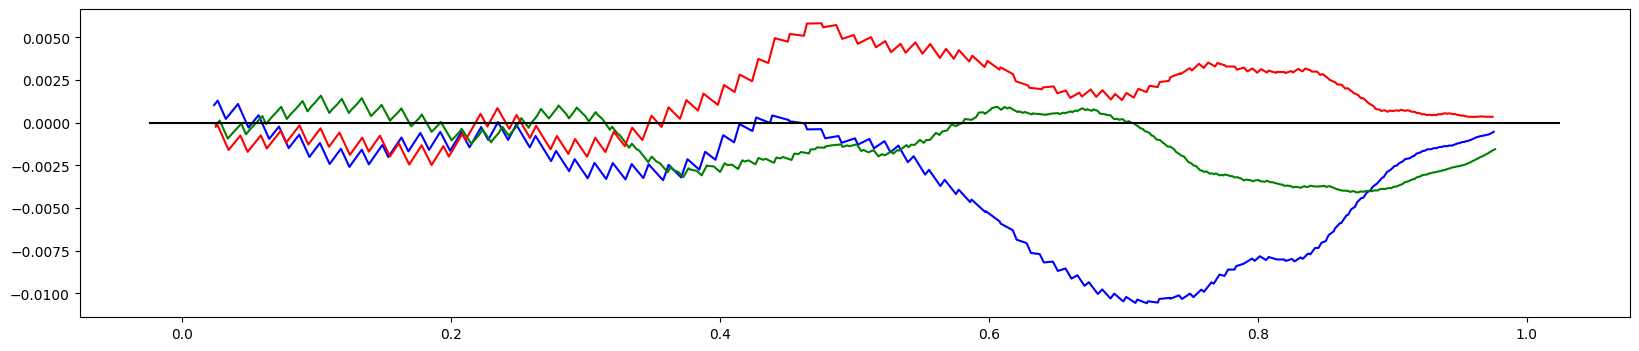


--------------------------------
Event Count: 13 Event413 Mogadishu Bombing 0.01933102456739566
Columns with over 5% nans: 8
[-1.53272522e-04 -4.99836954e-04 -4.67085920e-05 -5.36584136e-05
 -1.70076611e-03  2.10898125e-04 -4.74354275e-04 -8.51034601e-04
  5.75387306e-05 -1.81535129e-04 -6.25397063e-04 -1.14246378e-03
 -5.78601598e-04 -1.94508129e-04  1.23793696e-04 -1.75048629e-04
  1.67809232e-04 -1.43079450e-04  9.04490312e-04 -2.64932987e-04
  1.09894053e-04 -7.77511281e-05 -5.16979847e-04  8.02559596e-04
 -3.22848167e-04 -5.73649850e-05  1.01661410e-03 -3.90493096e-04
  1.25183660e-04  2.20627875e-04  4.11052985e-04  2.64180090e-04
  1.71979125e-04  1.86342089e-04  3.76303877e-04 -4.14122489e-04
  1.12688460e-03  5.42636272e-04  5.66120877e-05 -3.79373382e-04
  2.71129912e-04  2.82712947e-04  2.10898125e-04 -1.42616129e-04
  3.44798020e-04  1.51592982e-04  4.70821450e-04  7.79393524e-04]
0.9865694286844695


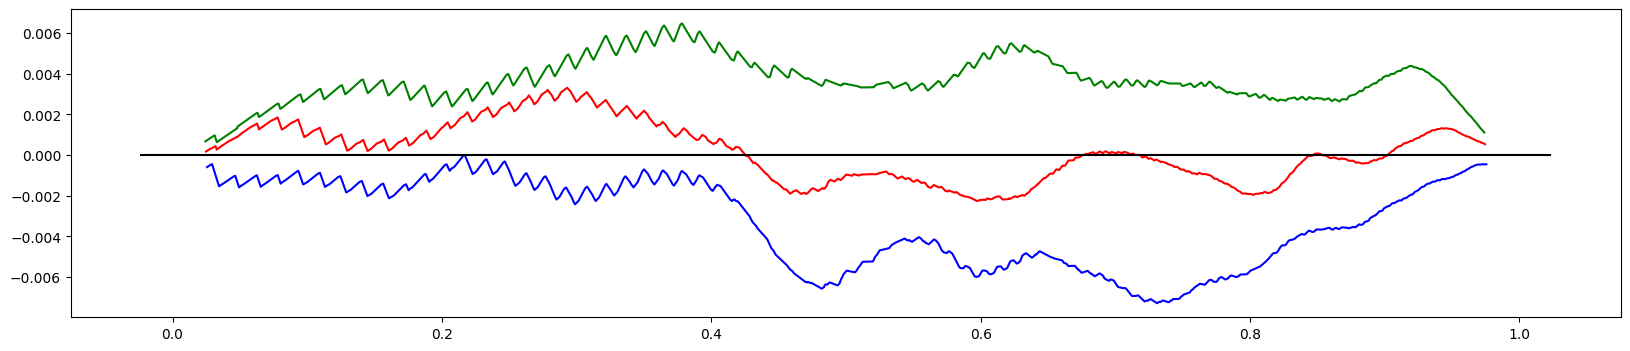


--------------------------------
Event Count: 14 Event56 Pierre Trudeau Funeral 0.021572192676071245
Columns with over 5% nans: 0
[ 1.01893508e-03  1.75797994e-03  4.58758484e-04 -2.56714592e-04
  8.09562143e-04  5.14221513e-04  1.87029258e-03 -4.04087784e-05
  5.98802632e-04 -1.03874330e-03 -6.35249766e-04 -5.90879343e-04
 -8.57101882e-04 -7.46175824e-04 -1.00031535e-04 -1.26772638e-05
  1.40440313e-03 -2.89992409e-04  1.55098399e-04  3.04848578e-04
  3.96164494e-06 -2.83059531e-04  1.85603065e-04  2.93755972e-04
 -1.67934129e-03 -1.28832693e-03 -4.24490255e-04 -1.13303045e-03]
0.9710589871334799


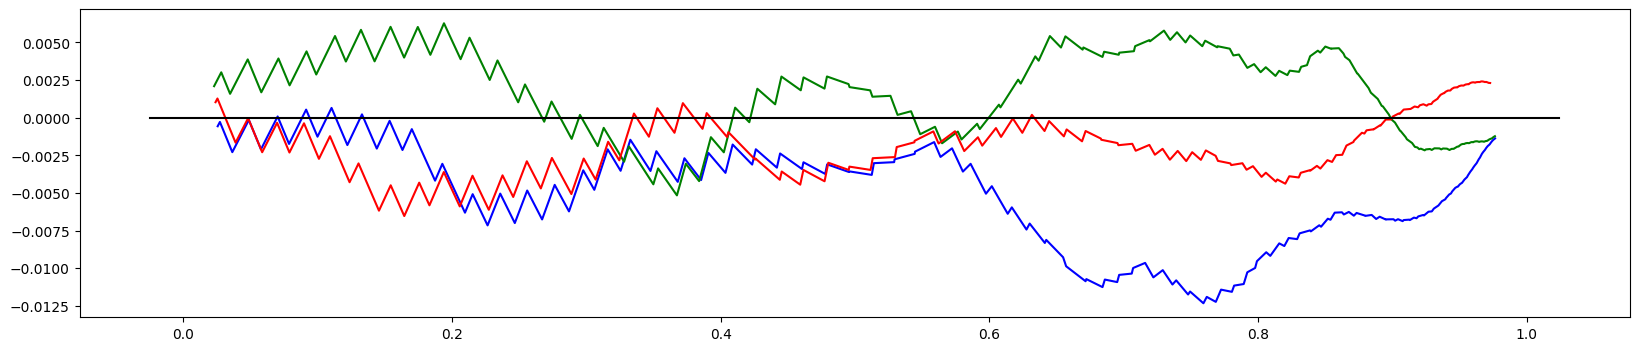


--------------------------------
Event Count: 15 Event205 Bali Bombing 2 0.022006592782255807
Columns with over 5% nans: 3
[ 1.15342923e-04 -3.94243930e-04  8.89610423e-05  2.06059565e-04
  2.40772566e-04  8.89610423e-05  1.42187644e-04 -8.22897621e-05
  4.89317653e-04 -1.16163267e-03  4.51827612e-04 -4.88663293e-04
 -4.79869332e-04 -8.32154421e-05 -1.95222725e-04  5.53652414e-04
  4.96196413e-05 -1.62823924e-04  5.69851815e-04  3.73144810e-04
 -3.06767168e-04 -6.09464536e-04 -5.05788373e-04 -4.46544851e-04
  3.43060209e-04  4.37942411e-04 -7.98766100e-04  7.69272020e-05
 -2.55391927e-04 -7.85806580e-04 -2.81310967e-04 -4.45619171e-04
 -3.18801008e-04 -1.52641444e-04  1.03771923e-04  4.26770411e-05
  1.06555347e-03  2.23184646e-04 -1.83651725e-04  8.80417463e-04
  1.80140525e-04 -1.32276483e-04 -4.89652813e-05 -1.96611245e-04
  3.00941768e-04  7.18359618e-05 -3.49811289e-04  1.07110755e-03
  3.62499489e-04 -5.45129774e-04  7.09102818e-05  2.37995526e-04
  6.11507416e-04  4.80060852e-0

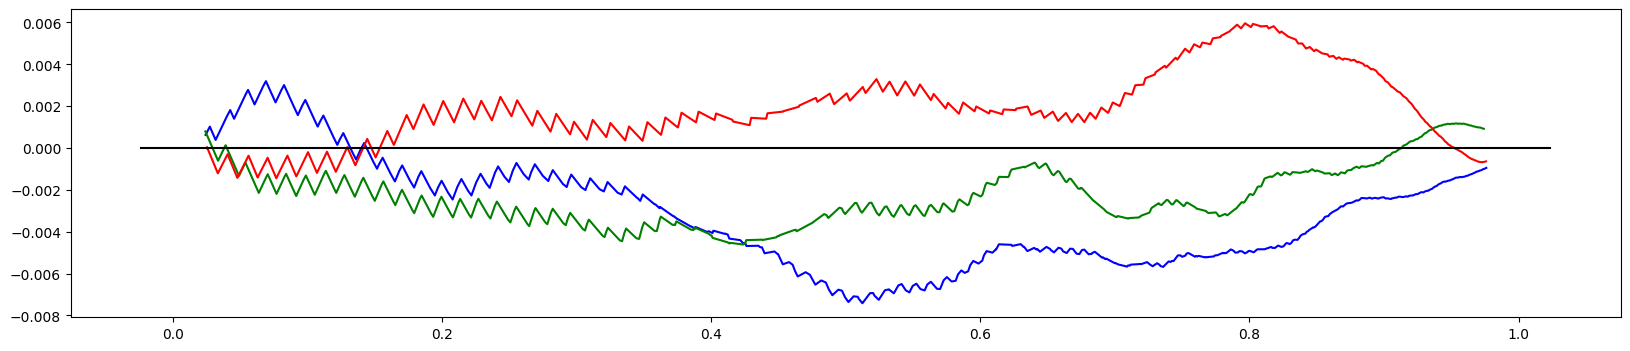


--------------------------------
Event Count: 16 Event324 Health Care is Law 0.02369816101463118
Columns with over 5% nans: 3
[ 5.73646045e-04 -3.42632730e-04 -1.54004249e-03  1.41884380e-04
  6.56944116e-04  4.25791970e-04 -1.07079670e-03 -5.99468447e-04
 -6.93872927e-04  2.18935095e-04  2.95985810e-04  7.45101240e-04
  4.54946295e-04  5.88223208e-04  4.61193650e-04  2.11993589e-04
 -5.94192903e-05 -1.44105662e-04 -8.47280207e-04  3.13339575e-04
 -5.31719350e-05  1.42578531e-04 -7.81335901e-04 -5.70314123e-04
  1.71732855e-04  1.22448164e-04 -3.99553078e-04  6.81239386e-04
  8.02021589e-04 -2.14214871e-04 -8.23679087e-04 -6.26540320e-04
  3.31387490e-04  3.13339575e-04  1.00235345e-04  3.60541815e-04
  7.52042746e-04 -1.69095083e-04 -2.31568636e-04  7.99244986e-04
  3.32775792e-04  1.41884380e-04 -5.55736960e-04  4.74382511e-04
  7.46489542e-04  1.11577765e-03 -4.99510763e-04  2.68219787e-04
 -1.13327025e-03  4.76464963e-04  1.00929495e-04  4.53557994e-04
 -1.52435469e-04  9.05172366

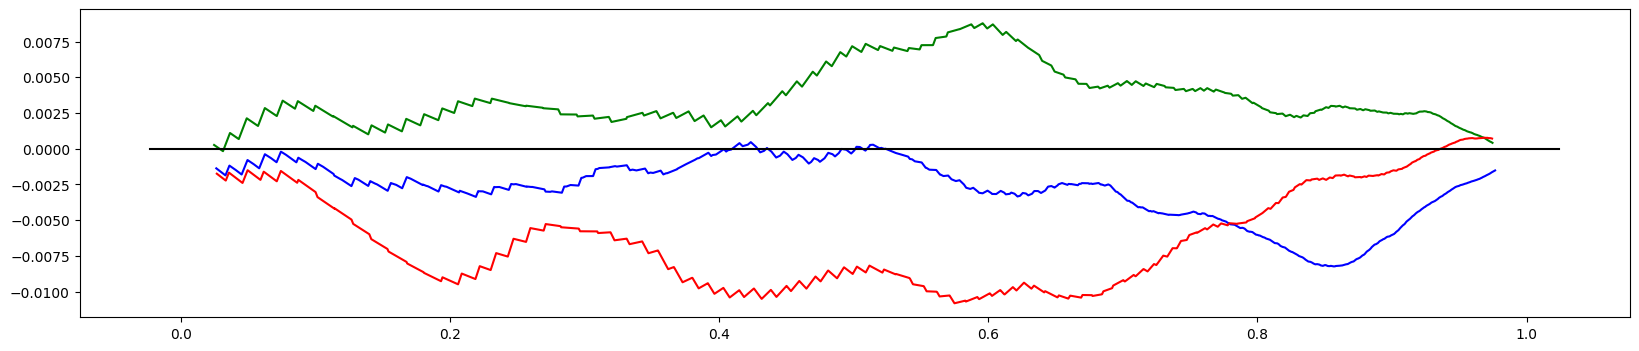


--------------------------------
Event Count: 17 Event272 Palin Acceptance 080903 0.023929771799067412
Columns with over 5% nans: 1
[ 8.75682867e-04 -3.77189180e-04  1.02674819e-03  8.42420777e-04
 -4.97764255e-04 -1.48731142e-03  4.40503859e-04  2.10499427e-03
  1.49460574e-04  1.91840561e-05 -8.60875401e-04 -2.31667537e-04
  6.60865204e-04  3.49033113e-04 -6.51601420e-04 -1.14498908e-03
  1.37600013e-03 -8.35928834e-04 -5.29640424e-04  1.34215450e-04
 -7.61089132e-04 -1.02718585e-03  8.03615006e-04  4.40503859e-04
 -4.10451270e-04  1.28175755e-03  2.20142515e-04  4.69024642e-05
 -6.32198534e-04  1.48271600e-03  3.87838884e-04 -1.97376949e-03
 -2.56614105e-04  1.97967788e-04  3.97540327e-04  9.02015354e-04
  5.88797343e-04  6.21475887e-05 -8.76120526e-04  3.62892317e-04
  4.98712516e-04  8.57082356e-05 -1.73458880e-04 -3.73031419e-04
  3.29630227e-04  6.63053499e-05 -2.52456343e-04 -1.12142844e-03
 -1.89338610e-03 -1.44019013e-03 -5.26868584e-04  7.12144259e-04
  9.28347842e-04  6.42

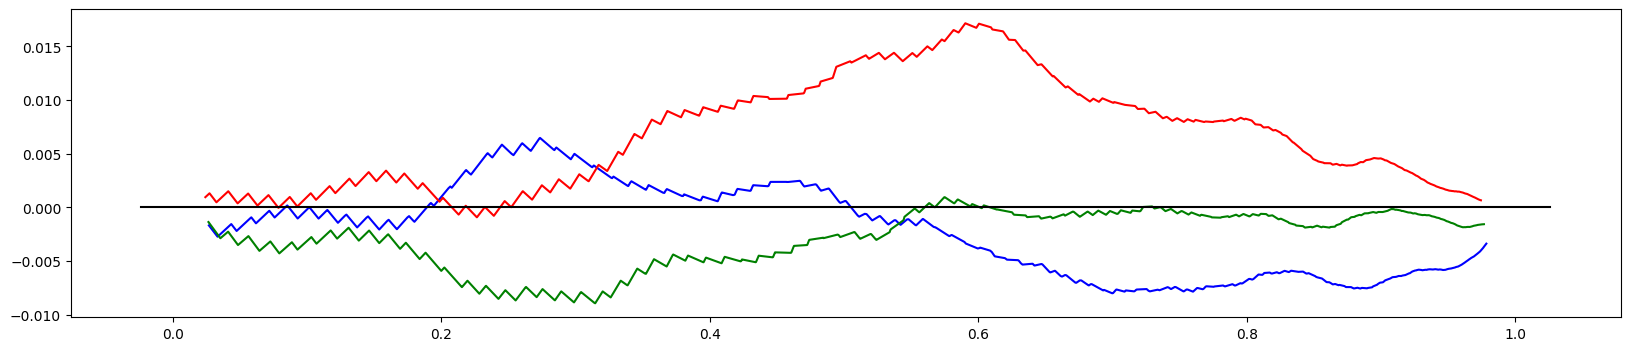


--------------------------------
Event Count: 18 Event197 Pope Paul's Funeral 0.02405880370764557
Columns with over 5% nans: 5
[-7.35276715e-04  4.56735744e-04  1.29478279e-03  2.00819981e-04
 -6.74290724e-05  2.05136632e-04 -3.82544627e-04  1.55803473e-04
 -7.60623752e-05  1.03886702e-03 -3.44311428e-04  4.04021563e-07
 -5.73710619e-04  4.15419224e-04 -5.00944209e-04  8.48870567e-05
  2.45836489e-04 -5.81110593e-04 -6.16877133e-04 -4.46677734e-04
  7.33618100e-04 -7.61261681e-06 -3.15328197e-04 -6.92110201e-04
  1.46929884e-03 -7.61261681e-06  9.50067337e-04 -6.41543713e-04
 -3.90625058e-05 -2.56745071e-04  6.39885098e-04 -6.19343791e-04
  6.78118296e-04 -4.05977878e-04 -2.15428550e-04  1.12636959e-04
 -3.59728041e-04  6.79968290e-04  6.47901736e-04 -2.16045215e-04
  7.97751207e-04  1.65670105e-04  1.17570275e-04 -4.28177799e-04
  1.03386991e-04  2.43369831e-04  4.39469139e-04 -8.40109679e-04
  1.41620190e-04 -1.08492548e-03 -7.29110070e-04  2.50769805e-04
 -9.76456324e-05 -1.8151200

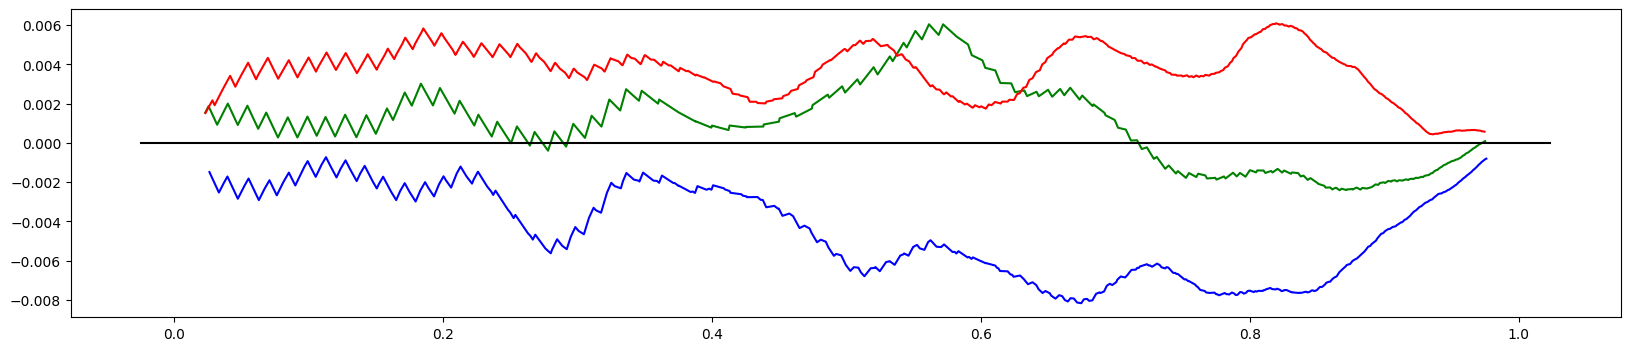


--------------------------------
Event Count: 19 Event183 Russian School Hostage Crisis 0.02484189157168082
Columns with over 5% nans: 1
[ 1.06259733e-03 -1.69194013e-04 -1.94797741e-06  5.06729799e-04
  1.67891303e-05 -6.37110363e-05 -4.70375671e-04 -3.74608231e-04
 -2.26099303e-04  3.24216491e-04 -7.89783092e-05 -9.67256009e-04
  1.29230039e-03 -5.04380052e-04 -1.29637897e-04  6.76057736e-04
 -4.95358481e-04  1.61134257e-04 -6.99567388e-05  1.03345072e-03
 -6.86893360e-04  2.31918886e-04 -3.84323769e-04  4.17902029e-04
  3.31156160e-04 -2.19853601e-04  2.23591282e-04  2.25673183e-04
  2.39552522e-04  7.28799224e-04 -6.43173442e-04 -2.38590708e-04
 -1.17840459e-04  1.27217535e-03 -1.53926740e-04  1.20190206e-04
  2.15263679e-04 -1.97767189e-03 -1.27555996e-04 -1.06302345e-03
 -3.23254677e-04  1.47948884e-04 -6.04311293e-04  9.56420385e-04
 -3.46155586e-04  3.56138970e-04  2.72168969e-04 -4.41229059e-04
  1.90974836e-04  2.69393101e-04 -1.29637897e-04 -2.68431287e-04
  2.33306820e-04 

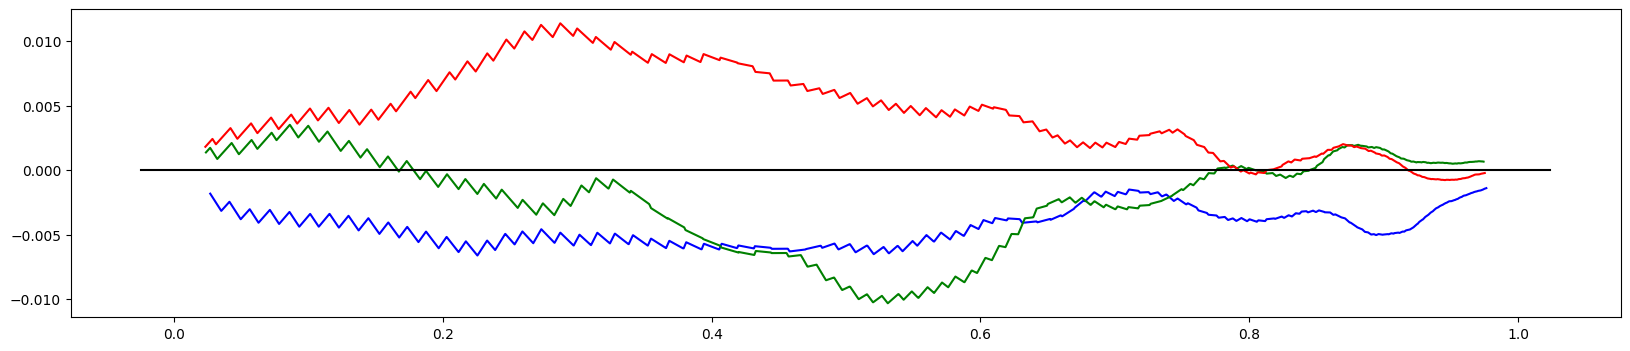


--------------------------------
Event Count: 20 Event198 Prince Charles' Wedding 0.026601505340722698
Columns with over 5% nans: 5
[ 1.44941234e-03 -5.68114076e-04 -7.52851434e-04 -6.38953213e-04
  4.56969912e-04 -4.52826852e-04 -5.85476609e-04  4.97945491e-04
 -9.48006312e-04 -4.91024426e-04 -1.95861354e-04  4.64609427e-04
 -7.68824965e-04 -1.16746874e-03  2.76399562e-04 -6.23674183e-04
 -6.54232243e-04 -4.88246421e-04  6.19483227e-04  9.98680962e-04
 -5.31305504e-04  5.49338591e-04 -9.72421627e-05 -7.90354507e-04
  5.45171583e-04 -1.04187176e-04  3.84047271e-04  9.52843873e-04
  6.72959831e-04  6.74348833e-04 -3.84071219e-04 -8.05741304e-05
  1.02368301e-03  7.59772499e-04 -1.81971327e-04  2.21533955e-04
 -3.06981569e-04 -6.41731218e-04  7.47271475e-04 -8.92446205e-04
  1.08618813e-03 -1.02440146e-03 -3.10454076e-04  7.54216488e-04
 -3.92405235e-04  8.09082095e-04  1.18747756e-04 -7.98796290e-05
  7.72273523e-04 -3.86849224e-04  1.91670398e-04 -3.59069170e-04
 -3.22955100e-04 -5.08

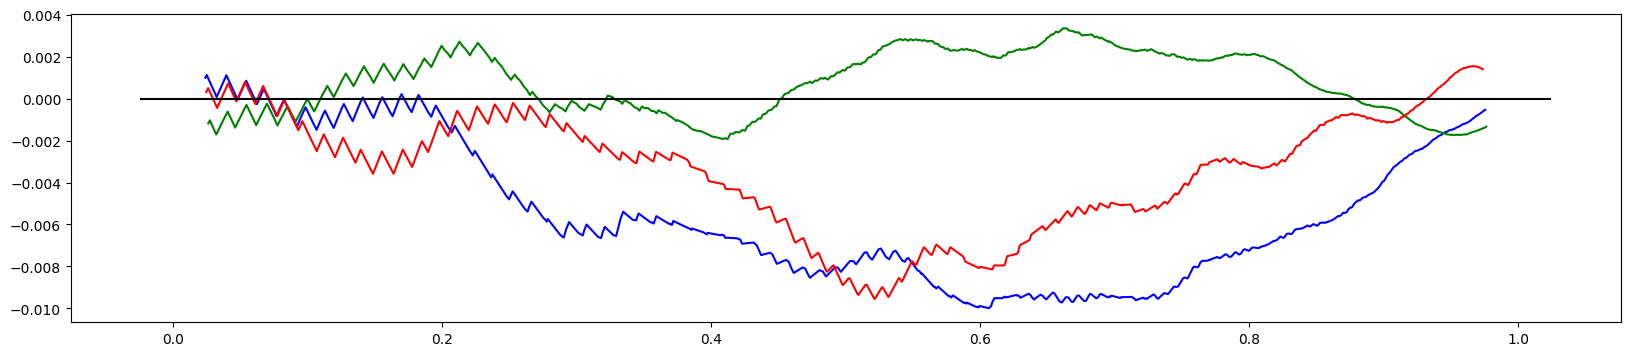


--------------------------------
Event Count: 21 Event80 Terrorist Disaster, Sept 11 0.027637015180042357
Columns with over 5% nans: 2
[-3.14663574e-04 -6.46419326e-04 -6.47751678e-04 -3.05337107e-04
  3.55509692e-04  4.54769947e-04  8.53809496e-04 -2.03412147e-04
  3.96146441e-04  3.60172926e-04 -7.81653096e-04 -8.94903052e-04
  2.26271508e-04  9.30362659e-05 -4.88592665e-05 -5.55210286e-05
 -7.95033721e-05  7.80530113e-04  6.94593382e-04 -6.01119344e-04
 -6.27766392e-04  1.06359790e-04  4.15465551e-04 -1.47453345e-04
  2.12281807e-04  1.31674486e-04  3.78825859e-04  5.96665480e-04
  7.95185990e-04  3.06878829e-04 -5.14516436e-04  6.15318414e-04
 -8.93570699e-04 -1.01614712e-03  5.10100640e-06]
0.9985256645534616


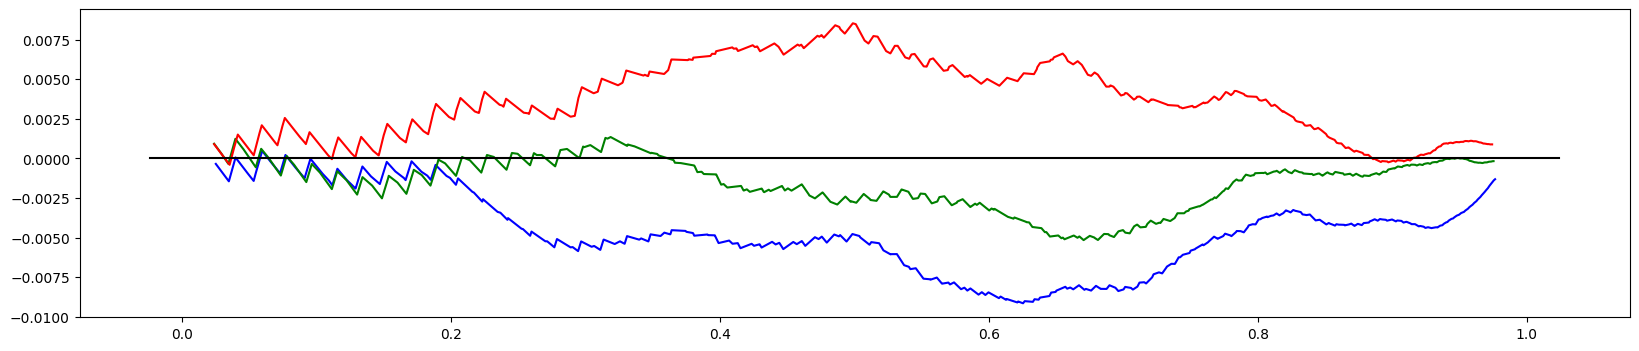


--------------------------------
Event Count: 22 Event271 Obama Acceptance 080828 0.029115800673962022
Columns with over 5% nans: 3
[-9.12888392e-04  1.50925881e-03  9.31498927e-04  4.81929518e-05
 -1.23926717e-03  6.73173595e-04 -4.39291950e-04  1.25371117e-03
 -2.85130058e-04 -9.86497224e-04  6.12064376e-04 -7.24005354e-04
  2.24576378e-04  2.06521381e-04 -6.94839590e-04 -4.68457713e-04
  1.70411389e-04  1.27454386e-03 -3.80960423e-04 -1.08927182e-03
 -1.29579320e-04 -2.57950344e-03  8.10669336e-04  8.06502799e-04
  1.50967546e-04 -4.46236179e-04  9.35665465e-04 -3.28184280e-04
  1.22037887e-03 -6.21230759e-04  1.29398770e-03 -9.04555317e-04
  2.02174294e-03 -1.37912395e-04  6.21786297e-04 -2.79574674e-04
 -5.28178086e-04 -9.06916355e-05 -5.01790014e-04  1.30093193e-03
 -3.58738889e-04 -6.80951132e-04  7.55115501e-04 -5.89287304e-04
 -1.07677221e-03  4.53735947e-04  1.21801783e-04 -1.18787988e-03
  1.81522156e-04  8.29140986e-05]
0.9944794492187832


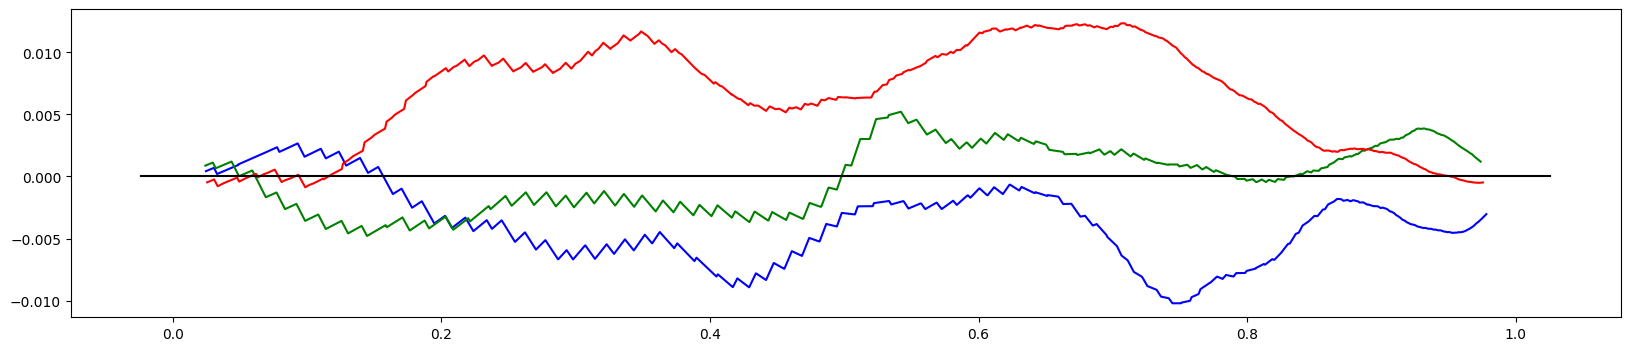


--------------------------------
Event Count: 23 Event335 Israel Attacks Flotilla 0.030555320881666792
Columns with over 5% nans: 1
[-4.12225194e-04 -4.42774108e-04 -8.08157634e-05  8.15285714e-04
 -3.82324287e-05 -3.62236062e-04  4.51013058e-04  4.38515775e-04
  3.48998199e-05 -4.57585703e-04  8.25746403e-05  2.92251277e-04
 -5.68209800e-04 -3.06692582e-04  6.22086976e-05  1.18215040e-04
  2.99657075e-04  2.00141673e-04 -4.99706175e-04 -2.48371928e-04
 -2.93732437e-04  3.22800191e-04  2.84382618e-04 -4.48328456e-04
 -2.10417217e-04 -5.52935343e-04 -1.15993301e-04 -8.14637707e-06
  1.57558338e-04  4.30184253e-04 -7.59834806e-04 -5.39975198e-04
 -1.19770257e-03 -1.41635874e-05 -5.55712517e-04 -3.33538597e-04
 -7.12622848e-04  9.41461986e-05  2.76051096e-04  1.71444208e-04
  3.15394394e-04  1.80701455e-04  6.12089150e-04 -8.35929374e-05
  3.92229541e-04  6.46340962e-04  5.81540236e-04 -3.07618307e-04
  5.54231358e-04  1.89495839e-04  6.37546578e-04  8.07879916e-04
 -4.83968856e-04  3.15

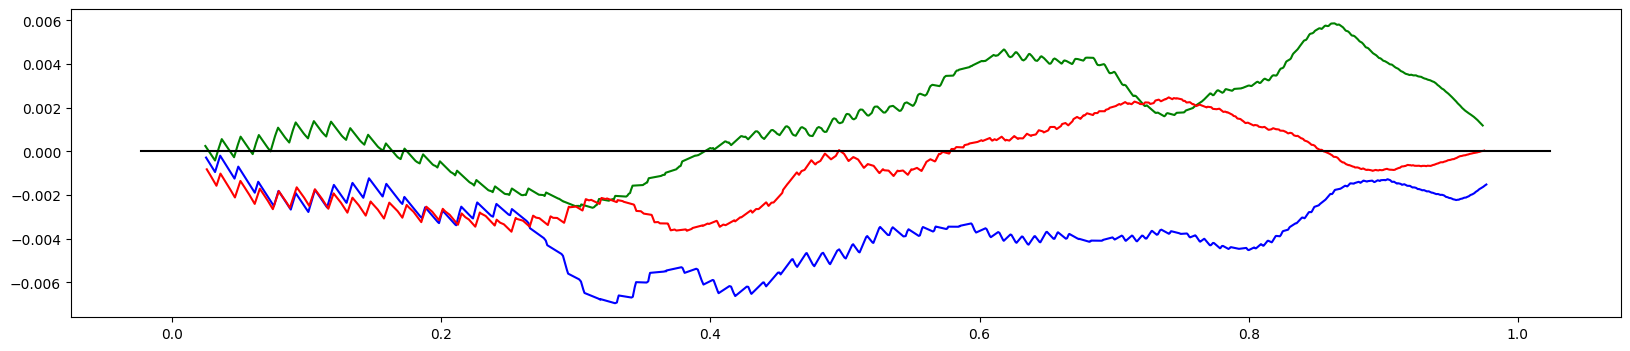


--------------------------------
Event Count: 24 Event204 End the War Rally 0.03441052029417613
Columns with over 5% nans: 4
[-3.26963404e-04 -4.99504615e-05 -6.45647348e-04 -4.52770142e-04
  3.08420151e-04 -1.70201066e-04 -4.67057342e-04  4.13288750e-05
  4.46132889e-04 -5.15078211e-04 -1.85678866e-04 -5.57542945e-04
 -4.67057342e-04  2.59208682e-04  2.66448078e-05 -7.06367950e-04
  2.26268748e-04  8.89528766e-05  2.78258283e-04  1.33908292e-03
  1.48879745e-04 -4.26180074e-04 -2.77355069e-04  4.68357423e-04
  2.18824076e-05  4.50895289e-04 -1.70105270e-05 -2.68227136e-04
 -1.76154066e-04  3.00482817e-04 -5.58336679e-04  5.87910089e-05
 -7.38993128e-07  2.46604744e-05  6.87126759e-05 -3.39266271e-04
 -1.18608397e-04  8.85464303e-04  5.06059757e-04 -3.34503871e-04
 -6.40091215e-04  4.84232090e-04  1.46101679e-04 -8.76527961e-05
 -1.90838133e-04  4.70341756e-04  4.13986688e-04 -2.46796335e-04
  4.68850085e-05 -1.80916466e-04  9.68902102e-05  2.74289616e-04
 -1.34483064e-04  8.04106634e

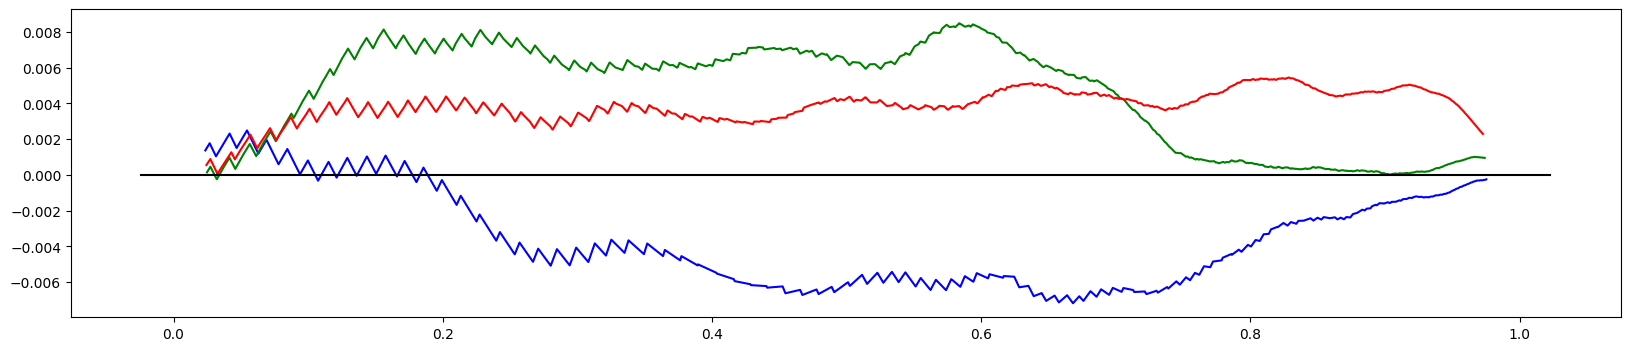


--------------------------------
Event Count: 25 Event398 Turkey Quake 7.2 0.03841941128743842
Columns with over 5% nans: 11
[-2.44170284e-05  1.16054089e-04 -1.98096721e-04 -2.08973397e-04
  2.25862235e-04 -4.77903115e-05  1.07375890e-04 -1.44754723e-04
  1.34104743e-04  8.00684895e-05 -2.85225841e-04  1.36650348e-04
  2.03761755e-04  2.80939873e-04 -4.36689343e-04 -2.63703907e-04
 -2.70067919e-04 -2.83027363e-04  4.05443103e-04  4.57028208e-05
 -1.31563861e-04 -1.44986142e-04  2.01563278e-04 -1.83170218e-04
 -1.58545386e-05  1.72057401e-04 -1.26935488e-04  2.47594335e-05
  6.04116010e-04  1.09921495e-04 -3.16351648e-04 -1.72872089e-04
 -7.09321759e-05  8.09941641e-05 -1.93258182e-05  2.54673857e-04
  3.40645883e-04  2.53516763e-04 -1.94972569e-04  3.49208373e-04
 -3.15910064e-05 -1.92889801e-04 -2.41856097e-05 -3.60668319e-04
 -4.44347411e-05 -1.54011469e-04  2.37180496e-05  1.48105571e-04
  4.82484259e-05]
0.9998830509047963


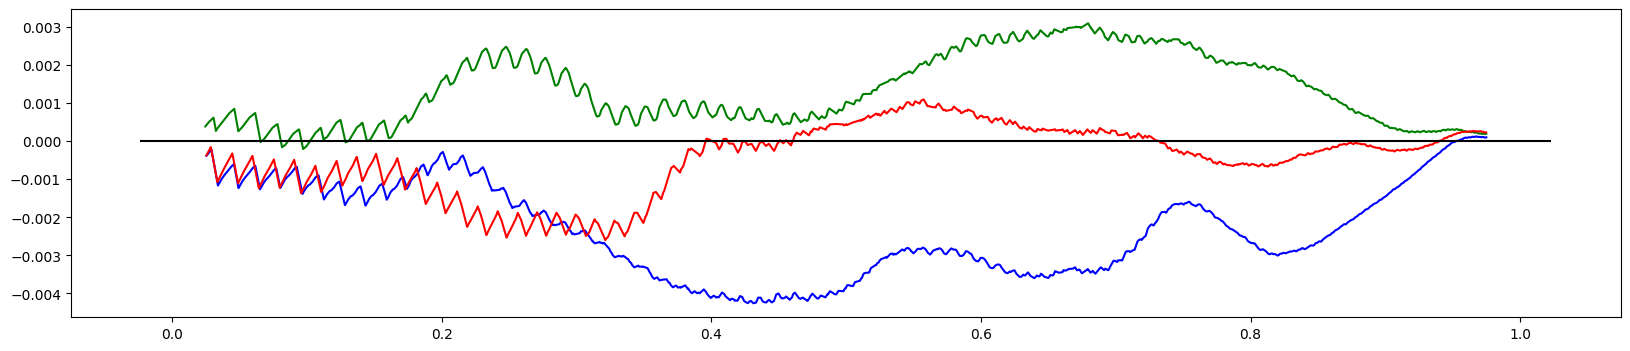


--------------------------------
Event Count: 26 Event181 Day of Murderous Violence 0.03988564698179242


KeyboardInterrupt: ignored

In [17]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt

%cd /content/drive/MyDrive/GCP_data/

def get_smoothed_mean(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = (arr_cumsum[windowsize:] - arr_cumsum[:-windowsize])/windowsize
  return smooth_arr

#NUM_PERMUTATIONS = 1000
#generalstats = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}

event_count = 0

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  egg_values_test = np.load("extracted/"+event+"_test_eggvalues.npy")
  print(perform_imabalance_test(egg_values_test))

  egg_values_control1 = np.load("extracted/"+event+"_control1_eggvalues.npy")
  egg_values_control2 = np.load("extracted/"+event+"_control2_eggvalues.npy")

  csm1_test, compositez_test = get_chisquareminus1(egg_values_test)
  csm1_control1, compositez_control1 = get_chisquareminus1(egg_values_control1)
  csm1_control2, compositez_control2 = get_chisquareminus1(egg_values_control2)

  plt.figure(figsize=(20,4))

  #compare cdf of actual chisquared to theoretical
  sorted_csm1_test = np.array(sorted(csm1_test))
  sorted_csm1_control1 = np.array(sorted(csm1_control1))
  sorted_csm1_control2 = np.array(sorted(csm1_control2))
  theoretical_cdf_test = scipy.stats.chi2.cdf(df=1, x=sorted_csm1_test+1)
  theoretical_cdf_control1 = scipy.stats.chi2.cdf(df=1, x=sorted_csm1_control1+1)
  theoretical_cdf_control2 = scipy.stats.chi2.cdf(df=1, x=sorted_csm1_control2+1)
  empirical_cdf = (np.arange(len(sorted_csm1_test))+1)/len(sorted_csm1_test)
  windowsize=int(len(csm1_test)/20)
  plt.plot(get_smoothed_mean(theoretical_cdf_test, windowsize), get_smoothed_mean(empirical_cdf-theoretical_cdf_test, windowsize), color="blue")
  plt.plot(get_smoothed_mean(theoretical_cdf_control1, windowsize), get_smoothed_mean(empirical_cdf-theoretical_cdf_control1, windowsize), color="green")
  plt.plot(get_smoothed_mean(theoretical_cdf_control2, windowsize), get_smoothed_mean(empirical_cdf-theoretical_cdf_control2, windowsize), color="red")
  plt.plot(plt.xlim(),[0,0], color="black")
  plt.show()

  ##compare cdf of actual chisquared to theoretical
  #sorted_compositez_test = np.array(sorted(compositez_test))
  #sorted_compositez_control1 = np.array(sorted(compositez_control1))
  #sorted_compositez_control2 = np.array(sorted(compositez_control2))
  #theoretical_cdf_test = scipy.stats.norm.cdf(sorted_compositez_test)
  #theoretical_cdf_control1 = scipy.stats.norm.cdf(sorted_compositez_control1)
  #theoretical_cdf_control2 = scipy.stats.norm.cdf(sorted_compositez_control2)
  #empirical_cdf = (np.arange(len(sorted_csm1_test))+1)/len(sorted_csm1_test)
  #windowsize=5000
  #plt.plot(get_smoothed_mean(theoretical_cdf_test, windowsize), get_smoothed_mean(empirical_cdf-theoretical_cdf_test, windowsize), color="blue")
  #plt.plot(get_smoothed_mean(theoretical_cdf_control1, windowsize), get_smoothed_mean(empirical_cdf-theoretical_cdf_control1, windowsize), color="green")
  #plt.plot(get_smoothed_mean(theoretical_cdf_control2, windowsize), get_smoothed_mean(empirical_cdf-theoretical_cdf_control2, windowsize), color="red")
  #plt.plot(plt.xlim(),[0,0], color="black")
  #plt.show()



In [12]:
import json

#save the stats
open("/content/drive/MyDrive/GCP_data/analysis/autocorr_generalstats.json", 'w').write(
     json.dumps(generalstats, indent=4))

1450134

In [13]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data


In [14]:
import json
import numpy as np
import scipy

generalstats = json.load(open("/content/drive/MyDrive/GCP_data/analysis/autocorr_generalstats.json"))

PearsonRResult(statistic=-0.012717770435443301, pvalue=0.8010643788204536)


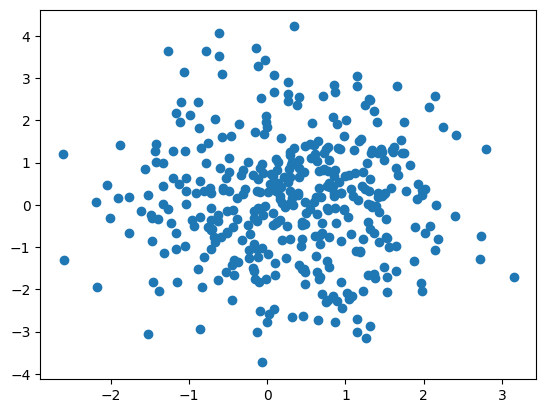

In [20]:
from matplotlib import pyplot as plt

threshold = len(generalstats['test'])
xvals = np.array([x['csm1_zscore'] for x in generalstats['test']][:threshold])
yvals = np.array([x['csm1_kurtautocorrz_z'] for x in generalstats['test']][:threshold])
#yvals = np.array([x['compositez_kurtosis_z'] for x in generalstats['test']][:threshold])

print(scipy.stats.pearsonr(xvals, yvals))

plt.scatter(xvals, yvals)
plt.show()

WilcoxonResult(statistic=27758.0, pvalue=2.904005217434688e-07)


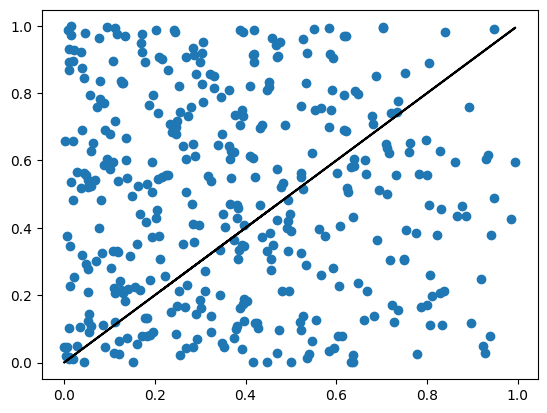

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
import scipy

threshold = len(generalstats['test'])

xvals = np.array([x['csm1_acminfdr'] for x in generalstats['test']][:threshold])
yvals = np.array([x['compositez_acminfdr'] for x in generalstats['test']][:threshold])

print(scipy.stats.wilcoxon(xvals-yvals, alternative='less')) #csm1 tends to have better signal than composite z


plt.scatter(xvals,yvals)
plt.plot(xvals,xvals,color="black")
plt.show()